In [14]:
%matplotlib inline
import psycopg2
import pytz
import datetime
import numpy as np
POSTGIS = psycopg2.connect(database='postgis', host='iemdb', user='nobody')
pcursor = POSTGIS.cursor()
ASOS = psycopg2.connect(database='asos', host='iemdb', user='nobody')
acursor = ASOS.cursor()

from matplotlib import pyplot as plt

In [3]:
def get_asos(sts, ets):
    acursor.execute("""SELECT valid, vsby, sknt, coalesce(gust, sknt) as gust,
    case when gust > sknt then gust else sknt end from t"""+`sts.year`+"""
 WHERE station = 'MCW' and valid BETWEEN %s and %s and sknt is not null ORDER by valid ASC""",
                    (sts.strftime("%Y-%m-%d %H:%M"), ets.strftime("%Y-%m-%d %H:%M")))
    valid = []
    vsby = []
    sknt = []
    gust = []
    for row in acursor:
        valid.append( row[0]) 
        vsby.append( row[1] )
        sknt.append( row[2] )
        gust.append( row[3] * 1.15)
        
    return valid, vsby, sknt, gust

0 82
1 40
2 57
13260.0 lightblue 2010-12-11 06:53:00-06:00
18300.0 lightblue 2010-12-11 06:53:00-06:00


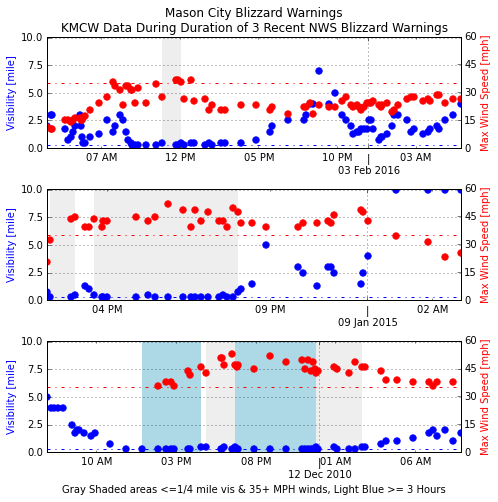

In [29]:
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

central = pytz.timezone("America/Chicago")
pcursor.execute("""select issue, expire from warnings where ugc = 'IAZ017' and wfo = 'DMX' 
  and phenomena = 'BZ' and significance = 'W' 
  and expire > issue and issue > '2007-01-01' ORDER by issue DESC""")
(fig, ax) = plt.subplots(3,1, figsize=(7, 7))
i = 0
for row in pcursor:
    valid, vsby, sknt, gust = get_asos(row[0], row[1])
    if valid[0].year < 2015 and valid[0].date() != datetime.date(2010, 12, 11):
        continue
    print i, len(valid)
    ax[i].scatter(valid, vsby, marker='o', s=40, color='b', zorder=2)
    ax[i].set_ylabel("Visibility [mile]", color='b')
    ax2 = ax[i].twinx()
    ax2.scatter(valid, gust, marker='o', s=40, color='r', zorder=2)
    ax2.set_ylabel("Max Wind Speed [mph]", color='r')
    ax[i].set_xlim(min(valid), max(valid))
    ax[i].set_ylim(0, 10.1)
    ax2.set_ylim(0, 60)
    
    ax[i].xaxis.set_major_locator(
                               mdates.DayLocator(interval=1,
                                                 tz=central)
                               )
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('|\n%d %b %Y',
                                                      tz=central))

    ax[i].xaxis.set_minor_locator(
                               mdates.HourLocator(interval=5,
                                                 tz=central)
                               )
    ax[i].xaxis.set_minor_formatter(mdates.DateFormatter('%I %p',
                                                      tz=central))
    ax[i].grid(True)
    ax[i].set_yticks(np.linspace(0, 10, 5))
    ax2.set_yticks(np.linspace(0, 60, 5))
    ax2.axhline(35, linestyle='-.', color='r')
    ax[i].axhline(0.25, linestyle='-.', color='b')

    hit = None
    for j in range(1,len(valid)):
        #print j, valid[j], valid[j-1], vsby[j], gust[j], hit
        if vsby[j] <= 0.25 and gust[j] >= 35:
            if hit is None:
                hit = j - 1
                continue
            if hit is not None:
                continue
        else:
            if hit is None:
                continue
            secs = (valid[j]-valid[hit]).total_seconds()
            sz =  secs / (24.0 * 3600.0)
            color = '#EEEEEE' if secs < (3*3600.) else 'lightblue'
            if color == 'lightblue':
                print secs, color, valid[0]
            #print 'HIT!', sz, hit, j
            rect = plt.Rectangle((valid[hit],0), sz , 60, 
 fc=color, zorder=1, ec='None') 
            ax[i].add_patch(rect)
            hit = None
    i += 1
ax[0].set_title("Mason City Blizzard Warnings\nKMCW Data During Duration of 3 Recent NWS Blizzard Warnings") 
ax[2].set_xlabel("Gray Shaded areas <=1/4 mile vis & 35+ MPH winds, Light Blue >= 3 Hours")
fig.tight_layout()

In [30]:
fig.savefig('160204.png')